# Fine-tuning CryptoBERT Model

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [161]:
import os
import sys

# PATH CONSTANTS
ABSOLUTE_PATH = "/content/drive/My Drive/sentix_nlp"
PREPROCESSED_DATA_DIR = ABSOLUTE_PATH + "/data/preprocessed"
EXPORT_MODEL_DIR = ABSOLUTE_PATH + "/models/finetuned_cryptobert"

sys.path.insert(0, ABSOLUTE_PATH)

In [162]:
!pip install --upgrade transformers

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset
from transformers import (
  AutoModelForSequenceClassification,
  AutoTokenizer,
  Trainer,
  TrainingArguments,
  EvalPrediction,
  get_linear_schedule_with_warmup
)

from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
  classification_report,
  confusion_matrix,
  ConfusionMatrixDisplay,
  accuracy_score,
  f1_score
)
from utils import NewsDataset, compute_metrics


# MODEL CONSTANTS
MODEL_NAME="ElKulako/cryptobert"
NUM_LABELS=3
BATCH_SIZE=16
NUM_EPOCHS= 3 #4
LEARNING_RATE= 5e-5 #2e-5
WEIGHT_DECAY=0.01
WARMUP_RATIO=0.1
WARMUP_STEPS=3

## Load the model and tokenizer

In [164]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    hidden_dropout_prob=0.3,          # increase dropout
    attention_probs_dropout_prob=0.3  # ditto
)

### Switch to CUDA

In [165]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Load the preprocessed data

In [166]:
test_set_path = os.path.join(PREPROCESSED_DATA_DIR, "coindesk_test.csv")
train_set_path = os.path.join(PREPROCESSED_DATA_DIR, "coindesk_train.csv")
val_set_path = os.path.join(PREPROCESSED_DATA_DIR, "coindesk_val.csv")

train_df = pd.read_csv(train_set_path)
val_df = pd.read_csv(val_set_path)
test_df = pd.read_csv(test_set_path)

df = pd.concat([train_df, val_df, test_df], ignore_index=True)
df.head()

,full_text,label
0,singapore exchange to launch bitcoin perpetual...,2
1,market madness continues – learn why hedera hb...,2
2,cardano price forecast can ada rise 5000 a blo...,1
3,when will cardano ada break the 1 barrier . ca...,0
4,bitpanda secures micar license from austria ’ ...,2


In [167]:
X_train, y_train = train_df['full_text'].values, train_df['label'].values
train_dataset = NewsDataset(X_train, y_train, tokenizer)

X_val, y_val = val_df['full_text'].values, val_df['label'].values
val_dataset = NewsDataset(X_val, y_val, tokenizer)

X_test, y_test = test_df['full_text'].values, test_df['label'].values
test_dataset = NewsDataset(X_test, y_test, tokenizer)

## Calculate class weights to handle imbalance

In [168]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [169]:
classes = ["Negative", "Neutral", "Positive"]
weights_np = class_weights.cpu().numpy()

df_class_weights = pd.DataFrame({
    "class": classes,
    "weight": weights_np
})

df_class_weights

,class,weight
0,Negative,1.489287
1,Neutral,1.278170
2,Positive,0.646760


## Training

In [170]:
def _compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred.predictions, eval_pred.label_ids
    preds = np.argmax(logits, axis=-1)
    return compute_metrics(preds, labels)

training_args = TrainingArguments(
    output_dir=EXPORT_MODEL_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    # warmup_steps=WARMUP_STEPS,
    warmup_ratio=WARMUP_RATIO,
    weight_decay=WEIGHT_DECAY,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    fp16=True,
    report_to=["tensorboard"],
    logging_dir="./logs",
    logging_steps=50,
)

# REF: https://discuss.huggingface.co/t/how-can-i-use-class-weights-when-training/1067/7
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def create_optimizer_and_scheduler(self, num_training_steps: int):
        # 1) set up AdamW with decoupled weight decay
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=self.args.learning_rate,
            weight_decay=self.args.weight_decay,
            betas=(0.9, 0.999),
            eps=1e-8
        )
        # 2) linear warmup + decay scheduler
        self.lr_scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=self.args.warmup_steps,
            num_training_steps=num_training_steps
        )
        return self.optimizer, self.lr_scheduler

    # function necessary to consider the computed weights
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    # data_collator=data_collator,
    compute_metrics=_compute_metrics,
    class_weights=class_weights
)

trainer.train()

<ipython-input-170-62a0a198b0d9>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.626100,0.579469,0.792503,0.789444,0.792503,0.790006
2,0.530900,0.605921,0.817269,0.810557,0.817269,0.811160
3,0.468300,0.644200,0.820616,0.816439,0.820616,0.817632


TrainOutput(global_step=2244, training_loss=0.5618619519334, metrics={'train_runtime': 420.6694, 'train_samples_per_second': 85.264, 'train_steps_per_second': 5.334, 'total_flos': 2359338016766976.0, 'train_loss': 0.5618619519334, 'epoch': 3.0})

## Evaluate on the test set

In [171]:
test_results = trainer.evaluate(test_dataset)
test_results

{'eval_loss': 0.6064049601554871,
 'eval_accuracy': 0.8180602006688963,
 'eval_precision': 0.8116839445602031,
 'eval_recall': 0.8180602006688963,
 'eval_f1': 0.8131393458945543,
 'eval_runtime': 6.5893,
 'eval_samples_per_second': 226.884,
 'eval_steps_per_second': 14.266,
 'epoch': 3.0}

In [172]:
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       335
           1       0.70      0.59      0.64       390
           2       0.86      0.92      0.89       770

    accuracy                           0.82      1495
   macro avg       0.80      0.78      0.79      1495
weighted avg       0.81      0.82      0.81      1495



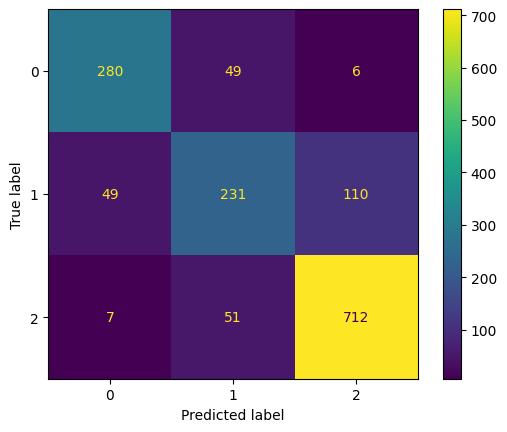

In [173]:
cm = confusion_matrix(y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()